# Diffraction Ring Based Detector Geometry Calibration

This notebook serves demonstrates how to use ipython based widgets to create a starting geometry from Power Based ring diffraction pattern.

In [61]:
%matplotlib notebook
#This important for interactive plots 
import os
import warnings
import sys

from matplotlib import pyplot as plt
import matplotlib.patches as patches

parent = os.path.dirname(os.path.abspath(os.path.dirname('.')))
sys.path.insert(0, parent)
warnings.filterwarnings('ignore')
import numpy as np

import karabo_data as kd
from geoAssembler import CalibrateNb as Calibrate
from geoAssembler.geometry import AGIPDGeometry, LPDGeometry

# Goemetry using AGIPD Data


## Get a run dataset with ring pattern

The example *instrument* has a some runs with interesting data. Run 005 contains data with diffraction patterns from Lithium Titanium. First open this run with karabo-data and read the data


In [2]:
run_dir = '/gpfs/exfel/exp/XMPL/201750/p700000/proc/r0005'
run = kd.RunDirectory(run_dir)
run.info()

# of trains:    156
Duration:       0:00:15.500000
First train ID: 198425241
Last train ID:  198425396

16 detector modules (SPB_DET_AGIPD1M-1)
  e.g. module SPB_DET_AGIPD1M-1 0 : 512 x 128 pixels
  176 frames per train, 27456 total frames

0 instrument sources (excluding detectors):

0 control sources:



## Define some parameters:
Detector distance to the sample, Beam wave length are certainly helpful variables that should be defined in the geometry file. Let's define those parameters:

In [3]:
clen = 0.119 #Detector distance in m
energy = 10235 #Photon energy in eV I believe

In [4]:
#Now construct the header of the geometry file from those properties
header = """data = /entry_1/data_1/data
;mask = /entry_1/data_1/mask

mask_good = 0x0
mask_bad = 0xffff

adu_per_eV = 0.0075  ; no idea
clen = {}  ; Camera length, aka detector distance
photon_energy = {} ;""".format(clen, energy)

## Read the train data

In [5]:
tId, train_data = run.train_from_index(3)
tId

198425244

Use the ```stack_detector_data``` to create a big with all pulses for the selected train data. 

In [6]:
train_array = kd.stack_detector_data(train_data, 'image.data', only='DET')
train_array.shape

(176, 16, 512, 128)

Let's apply the ```sum``` function over a train rather than selecting single pulses. This can help to get a clearer signal, if necessary.

In [7]:
data_array = np.sum(np.clip(train_array, 0, 2000), axis=0)
data_array.shape

(16, 512, 128)

### Start the geometry calibration without prior geometry knowledge
First lets assume that we have no prior knowledge about the detector geometry. We naively just assume that all modules equally spaced with 29px distance to each other.

<IPython.core.display.Javascript object>


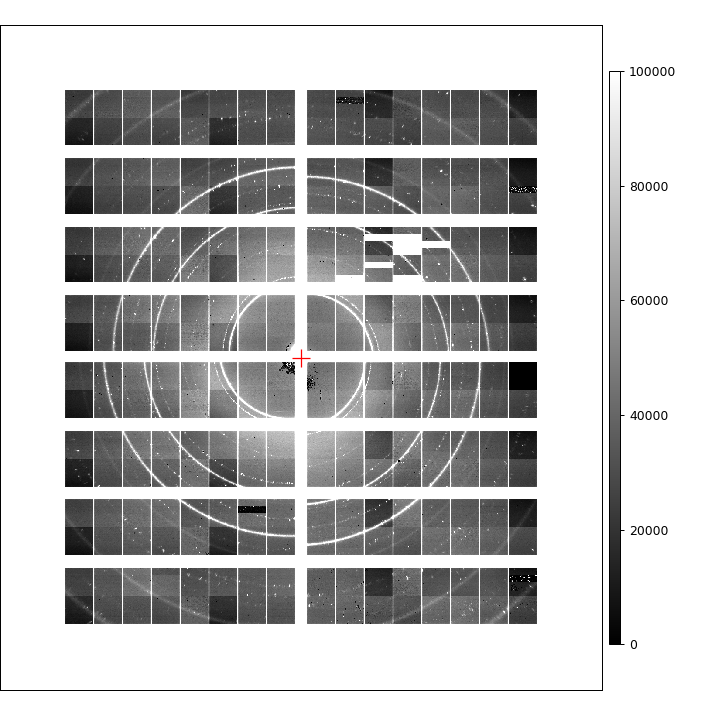

In [24]:
from geoAssembler import CalibrateNb as Calibrate
from geoAssembler import CalibrateNb as Calibrate
from geoAssembler.geometry import AGIPDGeometry, LPDGeometry
Calib =  Calibrate(data_array, geometry=None, vmin=0, vmax=1e5, figsize=(8,8), det='AGIPD')

Helper circles that guide the quadrant movement can be added by pushing the *Add circle* button. There can be multiple at a time. If there are different circles present, individual circles can be selected using the *Sel.* drop down menu. The radius can be adjusted with help of the *Radius* menu.

The quadrants can be moved by selecting a Quadrant from the *Quadrant* menu. The selected quadrant can be moved horizontally and vertically via the *Horizontal* and *Vertical* spin boxes.

The centre of the geometry can be retrieved with the ```centre``` attribute:

In [20]:
Calib.centre

array([660, 540])

Finally the geometry can be saved by calling ```C.geom.write_geom```. This method gets the output filename and the 'header' that contains information about detector distance and photon energy.

In [21]:
Calib.geom.write_geom('testing.geom', header)

The new geometry file could also be loaded for another round of refinement:

<IPython.core.display.Javascript object>


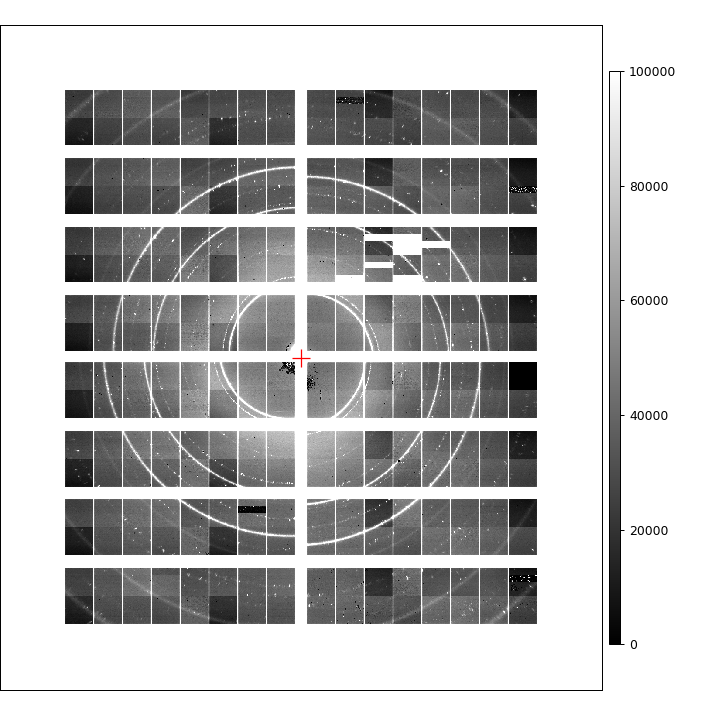

In [25]:
C_new =  Calibrate(data_array, geometry=Calib.geom, vmin=0, vmax=1e5, figsize=(8,8), det='AGIPD')

# Goemetry using LPD Data

Geometry description for LPD data is not saved in *CFEL* format but the inhouse EuXFEL format. The EuXFEL format requires quadrant positions. 

## Get a run dataset with ring pattern

The example *instrument* has a some runs with interesting data. Run 007 contains data with diffraction patterns from Lithium Titanium. First open this run with karabo-data and read the data


In [27]:
run_dir = '/gpfs/exfel/exp/XMPL/201750/p700000/proc/r0007'
run = kd.RunDirectory(run_dir)
run.info()

# of trains:    507
Duration:       0:00:50.600000
First train ID: 1487289920
Last train ID:  1487290426

13 detector modules (FXE_DET_LPD1M-1)
  e.g. module FXE_DET_LPD1M-1 0 : 256 x 256 pixels
  30 frames per train, 15180 total frames

0 instrument sources (excluding detectors):

0 control sources:



## Read the train data

In [28]:
tId, train_data = run.train_from_index(3)
tId

1487289923

Use the ```stack_detector_data``` to create a big with all pulses for the selected train data. 

In [29]:
train_array = kd.stack_detector_data(train_data, 'image.data', only='DET')
train_array.shape

(30, 16, 256, 256)

Let's apply the ```sum``` function over a train rather than selecting single pulses. This can help to get a clearer signal, if necessary.

In [30]:
data_array = np.sum(np.clip(train_array, 0, 2000), axis=0)
data_array.shape

(16, 256, 256)

### Start the geometry calibration without prior geometry knowledge
From a users perspective the EuXFEL format is a little more complicated. Quadrant positions and a geometry file descrbing in positioning of the tails within the quadrants is needed. Like in the AGIPD case no geometry information can be passed to the calibration. In this case a pixel gap of 4 pixels per module and asic is assumed. 

Yet it is recommended to at least read a geometry file and use the fallback quadrant positions:

### Create a geometry object from an existing EuXFEL geometry file without prior know ledge of quad positions

Let's use the geometry file that comes with the documentation of karabo_data

<IPython.core.display.Javascript object>


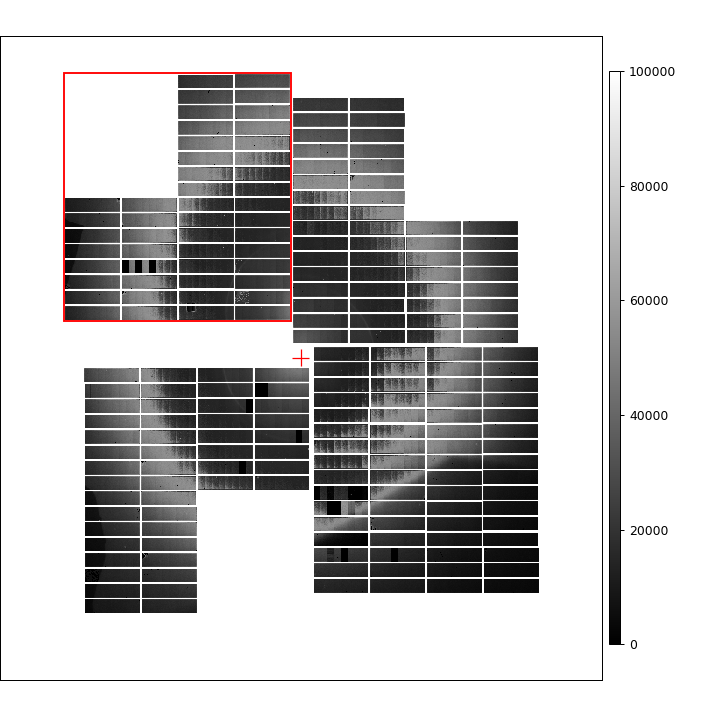

In [74]:
parent = os.path.dirname(os.path.dirname(kd.__file__))
geom_file = os.path.join(parent, 'docs', 'lpd_mar_18_axesfixed.h5')
geom = LPDGeometry.load(geom_file=geom_file, quad_pos=None)
Calib =  Calibrate(data_array, geometry=geom, vmin=0, vmax=100000, figsize=(8,8), det='LPD')

### Read the quadrant positions
Unlinke for CFEL geometry only the quadrant positions are of relevance they can be retreived using the 
```get_quad_pos``` method of the ```Calib.geom``` object.

In [76]:
Calib.geom.quad_pos

,Y,X
q1,11.4,299.0
q2,-11.5,-43.5
q3,254.5,-16.0
q4,278.5,275.0


The new geometry file could also be loaded for another round of refinement:

<IPython.core.display.Javascript object>


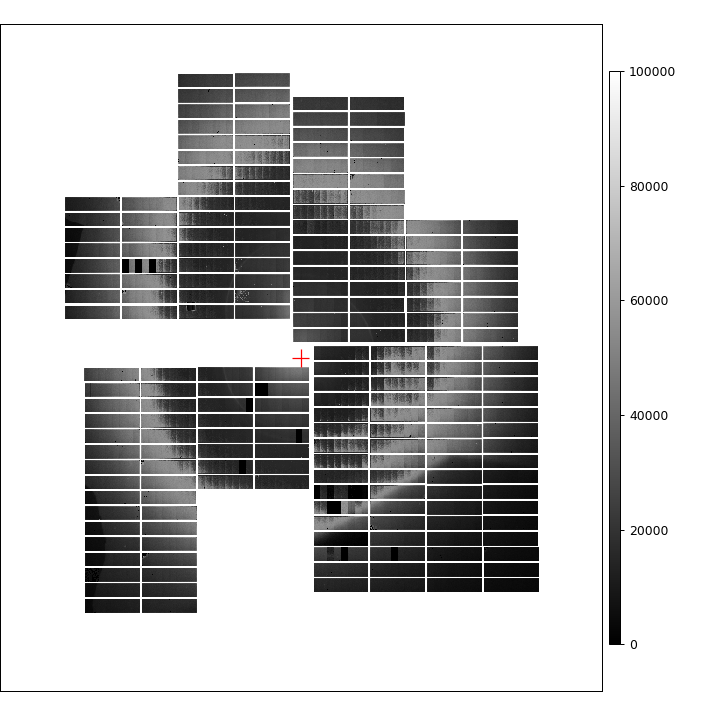

In [77]:
Calib_New =  Calibrate(data_array, geometry=Calib.geom, vmin=0, vmax=100000, figsize=(8,8), det='LPD')